# Lead Score - Case Study

## Problem Statement
An X Education need help to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%. <br>
## Goals and Objectives
There are quite a few goals for this case study.
- Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
- There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#Importing required packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Importing metrics from sklearn for evaluation
from sklearn import metrics
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

# 1. Loading and Cleaning Data

##  1.1  Reading the Data 

In [2]:
# importing/reading and  the data using Pandas

df = pd.read_csv(r'F:\Lead Scoring Assignment\Leads.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## 1.2 Inspect the dataframe
This helps to give a good idea of the dataframes.

In [3]:
# The .info() code gives almost the entire information like data type, null values etc.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          6779 non-null object
Specialization                                   7802 

In [4]:
# The shape code gives the total no. of rows and columns the data frame have

df.shape

(9240, 37)

In [5]:
# idea of the numeric values/ statistical information using by describe()

df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


## 1.3 Cleaning the dataframe

In [6]:
# Converting all the values to lower case for 'Select'

df = df.applymap(lambda s:s.lower() if type(s) == str else s)

In [7]:
# Replacing 'Select' with NaN (Since it means no option is selected by any professionals)

df = df.replace('select',np.nan)

In [8]:
# Checking for unique values, if there are columns with one unique value since it won't affect our analysis so far

df.nunique()

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        20
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     18
How did you hear about X Education                  9
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article           

In [9]:
# So we have to dropping unique valued columns which have 1 unique value

df1= df.drop(['Magazine','Receive More Updates About Our Courses',
              'Update me on Supply Chain Content',
              'Get updates on DM Content', 'I agree to pay the amount through cheque'],axis=1)

In [10]:
# Checking the percentage of missing values (coumn wise)

round(100*(df1.isnull().sum(axis=0)/len(df1.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Newspaper Article                                 0.00
X Educatio

In [11]:
# for reference

df1.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations', 'Tags',
       'Lead Quality', 'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score', 'A free copy of Mastering The Interview',
       'Last Notable Activity'],
      dtype='object')

In [12]:
# Removing all the columns which having greaterthan 40% null values

df2 = df1.drop(['How did you hear about X Education','Lead Quality',
                'Lead Profile','Asymmetrique Activity Index','Asymmetrique Profile Index',
                'Asymmetrique Activity Score','Asymmetrique Profile Score'],axis=1)
df2.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,api,olark chat,no,no,0,0.0,0,0.0,...,no,no,no,no,no,no,interested in other courses,NaN,no,modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,api,organic search,no,no,0,5.0,674,2.5,...,no,no,no,no,no,no,ringing,NaN,no,email opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,landing page submission,direct traffic,no,no,1,2.0,1532,2.0,...,no,no,no,no,no,no,will revert after reading the email,mumbai,yes,email opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,landing page submission,direct traffic,no,no,0,1.0,305,1.0,...,no,no,no,no,no,no,ringing,mumbai,no,modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,landing page submission,google,no,no,1,2.0,1428,1.0,...,no,no,no,no,no,no,will revert after reading the email,mumbai,no,modified


In [13]:
# Rechecking the percentage of missing values

round(100*(df2.isnull().sum(axis=0)/len(df2.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

#### There is a huge value of null variables in 6 columns as seen above. But removing the rows with the null value will cost us a lot of data and they are important columns. So, instead we are going to replace the NaN values with 'others'. This way we have all the data and almost no null values. In case these come up in the model, it will be of no use and we can drop it off then.

In [14]:
# imputing null values with 'others'

df2['Specialization'] = df2['Specialization'].fillna('others') 
df2['What matters most to you in choosing a course'] = df2['What matters most to you in choosing a course'].fillna('others')
df2['Country'] = df2['Country'].fillna('others')
df2['What is your current occupation'] = df2['What is your current occupation'].fillna('others')
df2['Tags'] = df2['Tags'].fillna('others')
df2['City'] = df2['City'].fillna('others')


In [15]:
df2.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,api,olark chat,no,no,0,0.0,0,0.0,...,no,no,no,no,no,no,interested in other courses,others,no,modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,api,organic search,no,no,0,5.0,674,2.5,...,no,no,no,no,no,no,ringing,others,no,email opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,landing page submission,direct traffic,no,no,1,2.0,1532,2.0,...,no,no,no,no,no,no,will revert after reading the email,mumbai,yes,email opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,landing page submission,direct traffic,no,no,0,1.0,305,1.0,...,no,no,no,no,no,no,ringing,mumbai,no,modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,landing page submission,google,no,no,1,2.0,1428,1.0,...,no,no,no,no,no,no,will revert after reading the email,mumbai,no,modified


In [16]:

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 25 columns):
Prospect ID                                      9240 non-null object
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9204 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9103 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9103 non-null float64
Last Activity                                    9137 non-null object
Country                                          9240 non-null object
Specialization                                   9240 

In [17]:
# Rechecking the percentage of missing values

round(100*(df2.isnull().sum(axis=0)/len(df2.index)), 2)

Prospect ID                                      0.00
Lead Number                                      0.00
Lead Origin                                      0.00
Lead Source                                      0.39
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                   

In [18]:
# checking the  columns having missing values less than 13%
column_wise_null_percent=((df2.isna().sum(axis=0)/len(df2))*100).round(2)

Col_ind = column_wise_null_percent.index # to know the index of each column. 

# collecting the all the columns having more than or equal to 1% and less than 10 % missing values

col_10 = []

for i in Col_ind:
    if column_wise_null_percent[i] >0 and column_wise_null_percent[i]<10:
        col_10.append(i) 
print('The list of columns having missing values less than 10%: \n',col_10)# list of columns having missing values more than or equal to 1% and less than 13%

print('No. of columns having missing values less than 10%: ', len(col_10)) # No. of columns having missing values more than or equal to 1% and less than 13%


The list of columns having missing values less than 10%: 
 ['Lead Source', 'TotalVisits', 'Page Views Per Visit', 'Last Activity']
No. of columns having missing values less than 10%:  4


### 1.4 Missing Value Imputation
### <font color = blue>___Columns having missing values less than 10%, need to be imputed.___</font>

In [19]:
# Inspecting the columns which have less than 10% missing values
df2[col_10].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 4 columns):
Lead Source             9204 non-null object
TotalVisits             9103 non-null float64
Page Views Per Visit    9103 non-null float64
Last Activity           9137 non-null object
dtypes: float64(2), object(2)
memory usage: 288.9+ KB


### <font color = green>By inspecting the above dataframe there are two categorical and two numerical variables are present.</font>
 
So, we imputing the null values for categorical variables with 'mode' and numerical values with 'mean' 
 

In [20]:
# impute the missing value with mean:
df2['TotalVisits'] = df['TotalVisits'].fillna(df2['TotalVisits'].mean())
df2['Page Views Per Visit'] = df['Page Views Per Visit'].fillna(df2['Page Views Per Visit'].mean())

In [21]:
df2['Lead Source'].mode()

0    google
dtype: object

In [22]:
df2['Last Activity'].mode()

0    email opened
dtype: object

In [23]:
# impute the missing value with mode:
df2['Lead Source'] = df['Lead Source'].fillna('google')
df2['Last Activity'] = df['Last Activity'].fillna('email opened')


In [24]:
# Grouping the response which is have very less count:
df2['Last Activity'] = df2['Last Activity'].str.replace('had a phone conversation','others')
df2['Last Activity'] = df2['Last Activity'].str.replace('approached upfront','others')
df2['Last Activity'] = df2['Last Activity'].str.replace('view in browser link clicked','others')
df2['Last Activity'] = df2['Last Activity'].str.replace('email received','others')
df2['Last Activity'] = df2['Last Activity'].str.replace('email marked spam','others')
df2['Last Activity'] = df2['Last Activity'].str.replace('visited booth in tradeshow','others')
df2['Last Activity'] = df2['Last Activity'].str.replace('resubscribed to emails','others')

df2['Last Activity'].value_counts()

email opened                 3540
sms sent                     2745
olark chat conversation       973
page visited on website       640
converted to lead             428
email bounced                 326
email link clicked            267
form submitted on website     116
unreachable                    93
unsubscribed                   61
others                         51
Name: Last Activity, dtype: int64

In [25]:
df2['Last Notable Activity'].value_counts()

modified                        3407
email opened                    2827
sms sent                        2172
page visited on website          318
olark chat conversation          183
email link clicked               173
email bounced                     60
unsubscribed                      47
unreachable                       32
had a phone conversation          14
email marked spam                  2
resubscribed to emails             1
approached upfront                 1
view in browser link clicked       1
form submitted on website          1
email received                     1
Name: Last Notable Activity, dtype: int64

In [26]:
# Grouping the response which is have very less count:
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('had a phone conversation','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('email marked spam','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('approached upfront','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('email received','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('email marked spam','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('form submitted on website','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('resubscribed to emails','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('email marked spam','others')
df2['Last Notable Activity'] = df2['Last Notable Activity'].str.replace('view in browser link clicked','others')
df2['Last Notable Activity'].value_counts()

modified                   3407
email opened               2827
sms sent                   2172
page visited on website     318
olark chat conversation     183
email link clicked          173
email bounced                60
unsubscribed                 47
unreachable                  32
others                       21
Name: Last Notable Activity, dtype: int64

In [27]:
# Rechecking the percentage of missing values
round(100*(df2.isnull().sum()/len(df2.index)), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                     

In [28]:
# dropping row wise null values

df2 = df2.dropna(axis=0, subset=['TotalVisits', 'Page Views Per Visit', 'Last Activity','Lead Source'])

In [29]:
# Rechecking the percentage of missing values

round(100*(df2.isnull().sum(axis=0)/len(df2.index)), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                     

In [30]:
df3 = df2

In [31]:
# Removing 'Prospect ID' because Id values are unique for everyone

df_final = df3.drop('Prospect ID', 1)
df_final.shape

(9240, 24)

# 2. EDA

### 2.1. Univariate Analysis

#### 2.1.1. Categorical Variables

In [32]:
# checking info of final dataframe

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9240 entries, 0 to 9239
Data columns (total 24 columns):
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9240 non-null object
Do Not Email                                     9240 non-null object
Do Not Call                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9240 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9240 non-null float64
Last Activity                                    9240 non-null object
Country                                          9240 non-null object
Specialization                                   9240 non-null object
What is your current occupation                  9240 

# 3. `Visualising the Data`


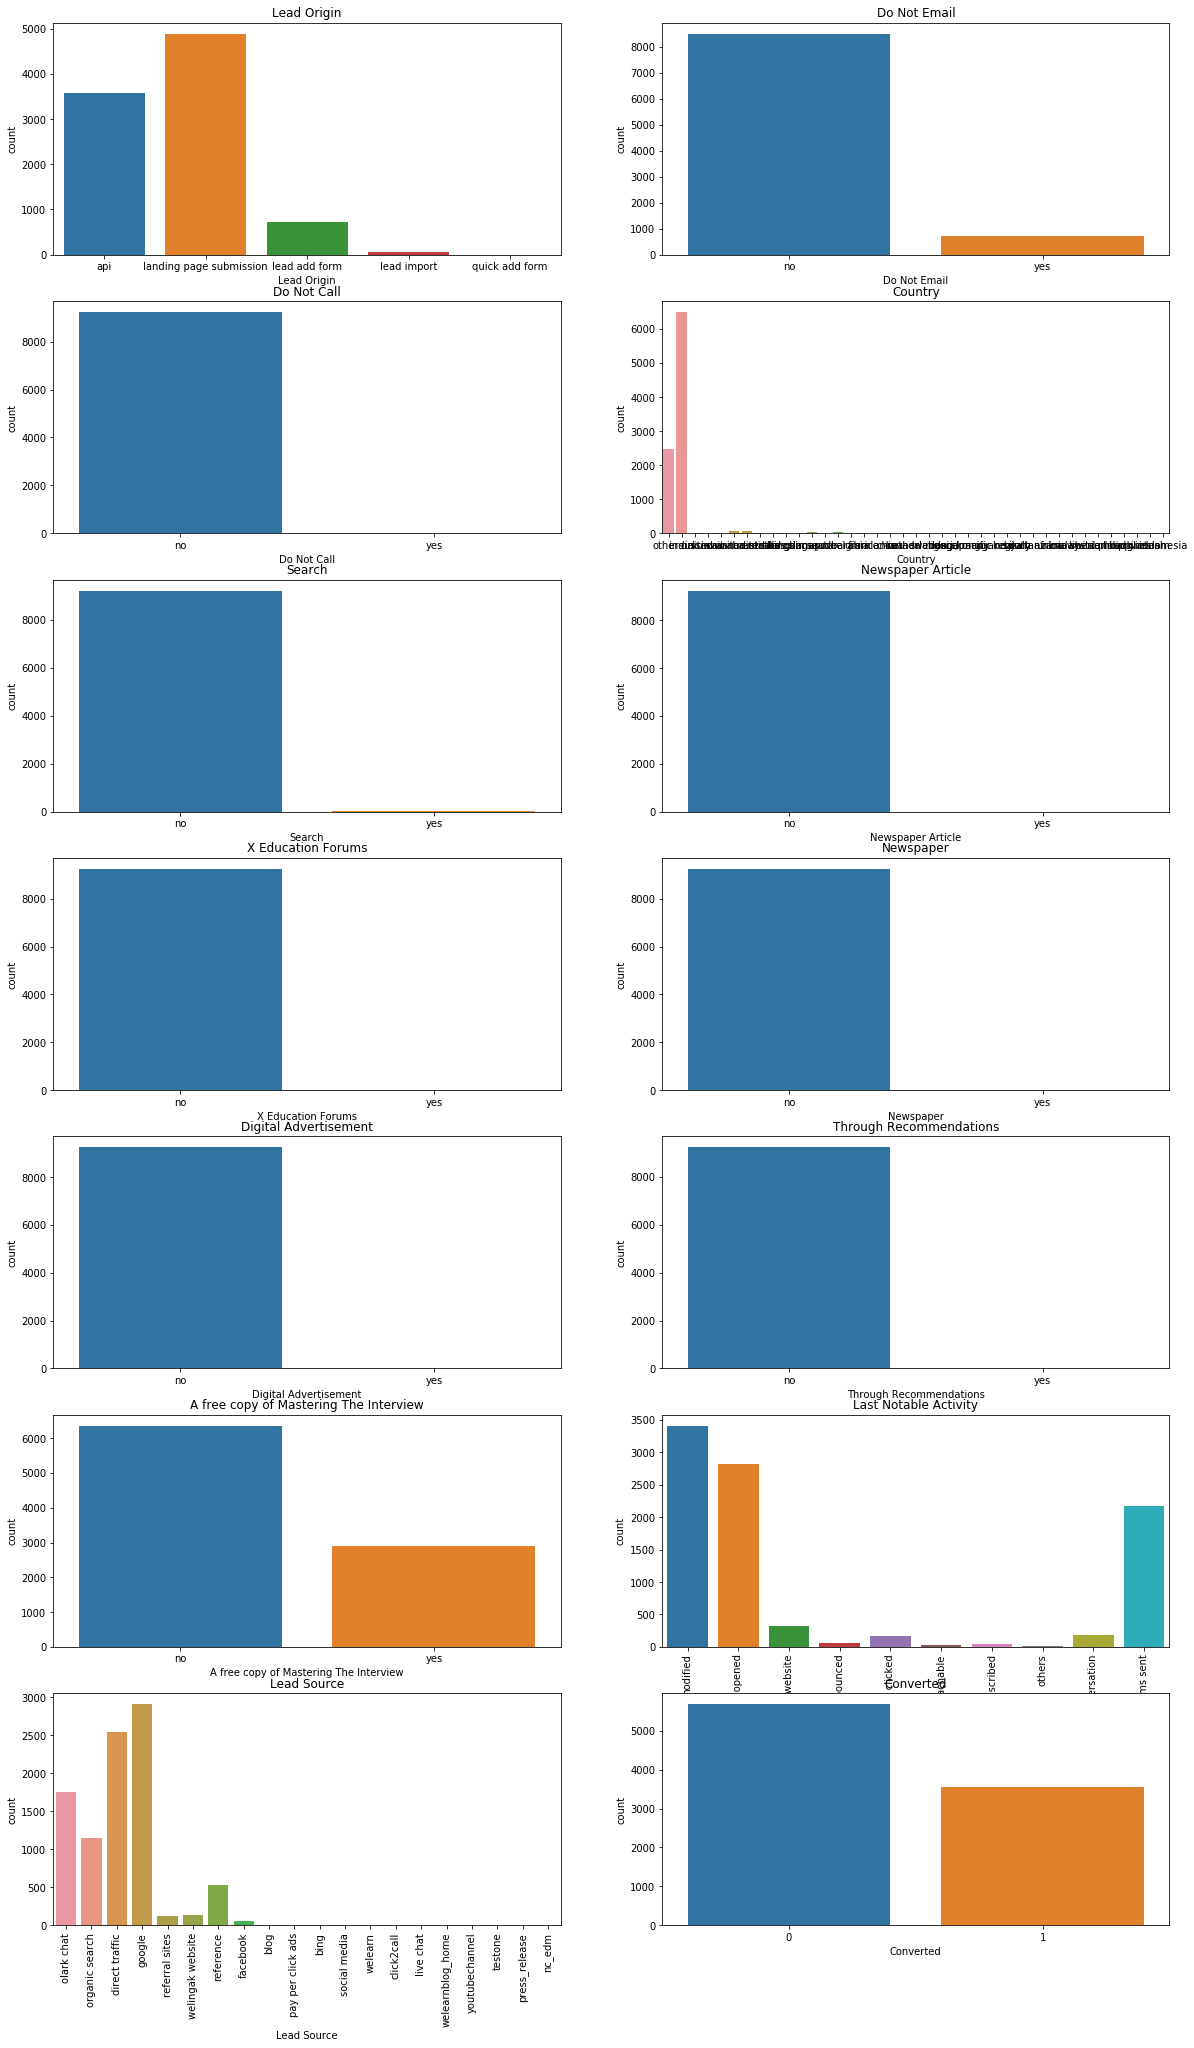

In [33]:
plt.figure(figsize = (20,35))

plt.subplot(7,2,1)
sns.countplot(df_final['Lead Origin'])
plt.title('Lead Origin')

plt.subplot(7,2,2)
sns.countplot(df_final['Do Not Email'])
plt.title('Do Not Email')

plt.subplot(7,2,3)
sns.countplot(df_final['Do Not Call'])
plt.title('Do Not Call')

plt.subplot(7,2,4)
sns.countplot(df_final['Country'])
plt.title('Country')

plt.subplot(7,2,5)
sns.countplot(df_final['Search'])
plt.title('Search')

plt.subplot(7,2,6)
sns.countplot(df_final['Newspaper Article'])
plt.title('Newspaper Article')

plt.subplot(7,2,7)
sns.countplot(df_final['X Education Forums'])
plt.title('X Education Forums')

plt.subplot(7,2,8)
sns.countplot(df_final['Newspaper'])
plt.title('Newspaper')

plt.subplot(7,2,9)
sns.countplot(df_final['Digital Advertisement'])
plt.title('Digital Advertisement')

plt.subplot(7,2,10)
sns.countplot(df_final['Through Recommendations'])
plt.title('Through Recommendations')

plt.subplot(7,2,11)
sns.countplot(df_final['A free copy of Mastering The Interview'])
plt.title('A free copy of Mastering The Interview')

plt.subplot(7,2,12)
sns.countplot(df_final['Last Notable Activity']).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')

plt.subplot(7,2,13)
sns.countplot(df_final['Lead Source']).tick_params(axis='x', rotation = 90)
plt.title('Lead Source')

plt.subplot(7,2,14)
sns.countplot(df['Converted'])
plt.title('Converted')

plt.show()


In [34]:
# Dropping Skew Columns:
Skew = ['Do Not Email','Do Not Call','Search','Newspaper Article','Newspaper',
        'X Education Forums','Digital Advertisement','Through Recommendations']
df_final = df_final.drop(Skew,axis = 1)
df_final.head()

,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,660737,api,olark chat,0,0.0,0,0.0,page visited on website,others,others,unemployed,better career prospects,interested in other courses,others,no,modified
1,660728,api,organic search,0,5.0,674,2.5,email opened,india,others,unemployed,better career prospects,ringing,others,no,email opened
2,660727,landing page submission,direct traffic,1,2.0,1532,2.0,email opened,india,business administration,student,better career prospects,will revert after reading the email,mumbai,yes,email opened
3,660719,landing page submission,direct traffic,0,1.0,305,1.0,unreachable,india,media and advertising,unemployed,better career prospects,ringing,mumbai,no,modified
4,660681,landing page submission,google,1,2.0,1428,1.0,converted to lead,india,others,unemployed,better career prospects,will revert after reading the email,mumbai,no,modified


In [35]:
# Inspect the dataframe after dropping skew columns(categorical)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9240 entries, 0 to 9239
Data columns (total 16 columns):
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9240 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9240 non-null float64
Last Activity                                    9240 non-null object
Country                                          9240 non-null object
Specialization                                   9240 non-null object
What is your current occupation                  9240 non-null object
What matters most to you in choosing a course    9240 non-null object
Tags                                             9240 

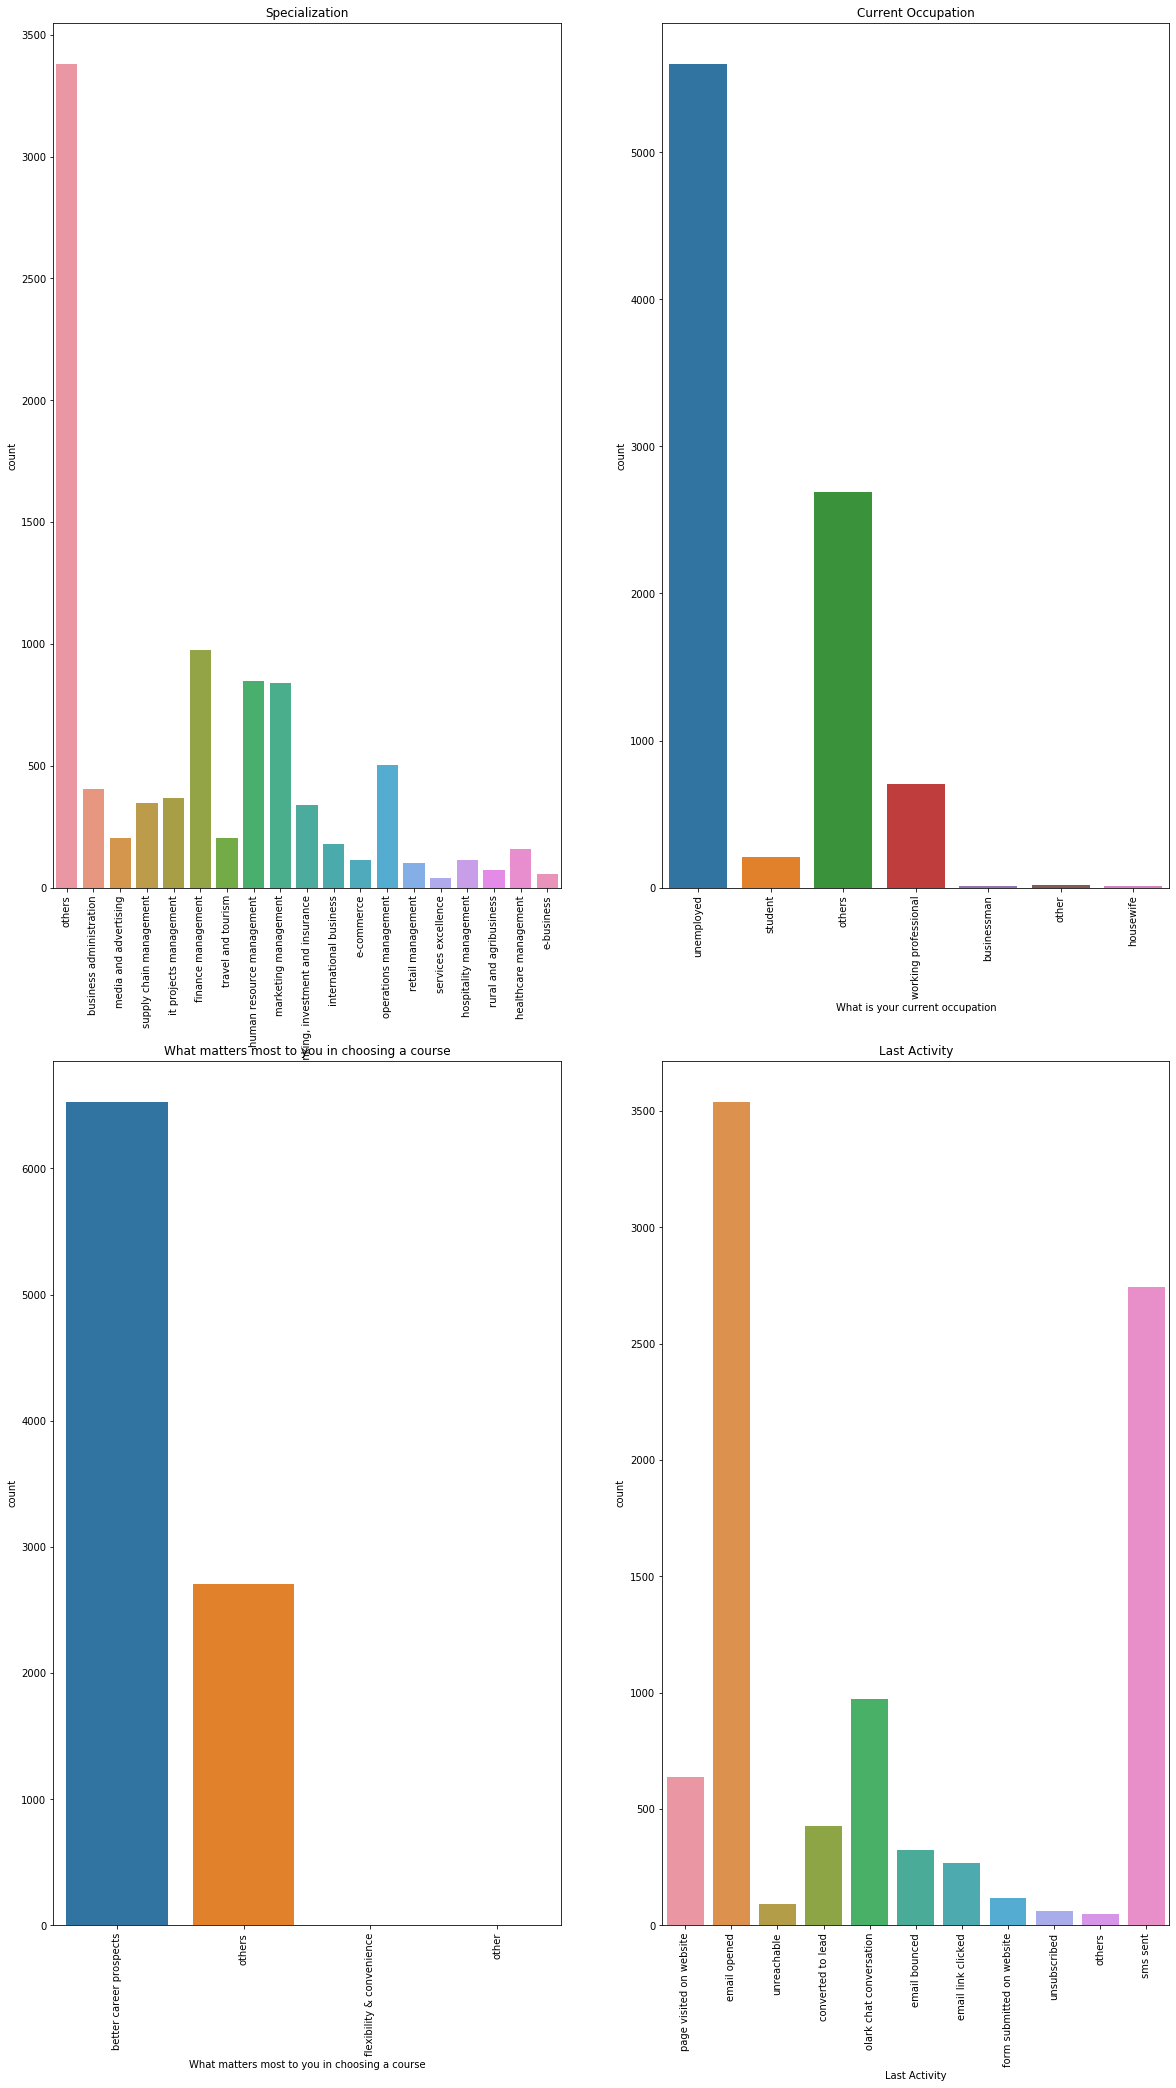

In [36]:
plt.figure(figsize = (20,35))

plt.subplot(2,2,1)
sns.countplot(df_final['Specialization']).tick_params(axis='x', rotation = 90)
plt.title('Specialization')

plt.subplot(2,2,2)
sns.countplot(df_final['What is your current occupation']).tick_params(axis='x', rotation = 90)
plt.title('Current Occupation')

plt.subplot(2,2,3)
sns.countplot(df_final['What matters most to you in choosing a course']).tick_params(axis='x', rotation = 90)
plt.title('What matters most to you in choosing a course')

plt.subplot(2,2,4)
sns.countplot(df_final['Last Activity']).tick_params(axis='x', rotation = 90)
plt.title('Last Activity')


plt.show()

In [37]:
# Count of Customers Not converted that is 0
df3_0 = df3['Converted'][df3['Converted'] == 0]
df3_0.count()

5679

In [38]:
# Count of Customers converted into Paying Customers that is 1
df3_1 = df3['Converted'][df3['Converted'] == 1]
df3_1.count()

3561

## 3.1. Numerical Variables

In [39]:
# identifying the numerical variables 

df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9240 entries, 0 to 9239
Data columns (total 16 columns):
Lead Number                                      9240 non-null int64
Lead Origin                                      9240 non-null object
Lead Source                                      9240 non-null object
Converted                                        9240 non-null int64
TotalVisits                                      9240 non-null float64
Total Time Spent on Website                      9240 non-null int64
Page Views Per Visit                             9240 non-null float64
Last Activity                                    9240 non-null object
Country                                          9240 non-null object
Specialization                                   9240 non-null object
What is your current occupation                  9240 non-null object
What matters most to you in choosing a course    9240 non-null object
Tags                                             9240 

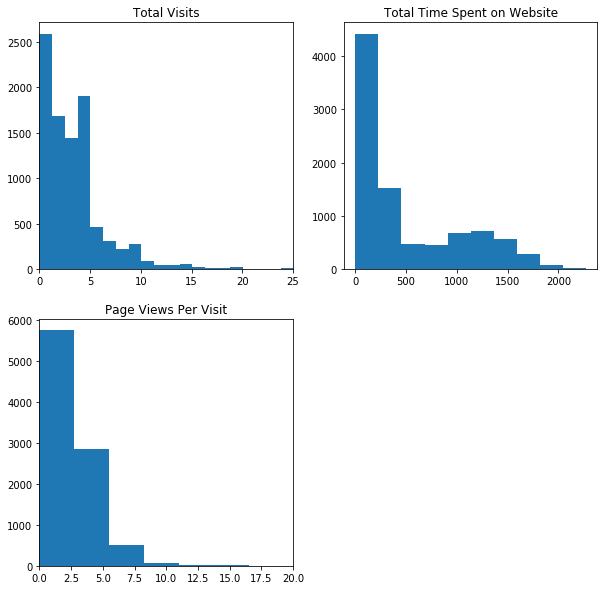

In [40]:
plt.figure(figsize = (10,10))

plt.subplot(2,2,1)
plt.hist(df_final['TotalVisits'], bins = 200)
plt.title('Total Visits')
plt.xlim(0,25)

plt.subplot(2,2,2)
plt.hist(df_final['Total Time Spent on Website'], bins = 10)
plt.title('Total Time Spent on Website')

plt.subplot(2,2,3)
plt.hist(df_final['Page Views Per Visit'], bins = 20)
plt.title('Page Views Per Visit')
plt.xlim(0,20)
plt.show()

###  Relating all the categorical variables to Converted

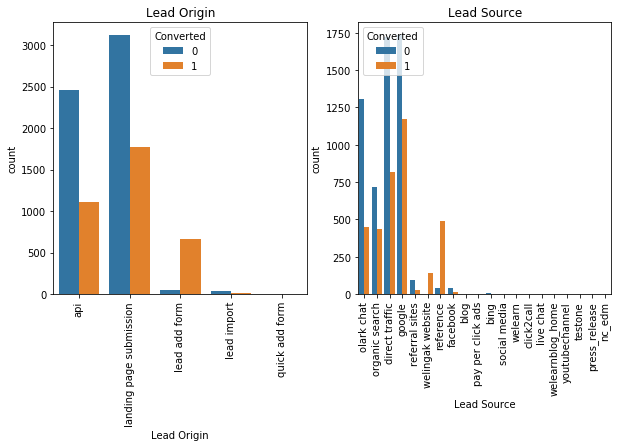

In [41]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.countplot(x='Lead Origin', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('Lead Origin')

plt.subplot(1,2,2)
sns.countplot(x='Lead Source', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('Lead Source')
plt.show()

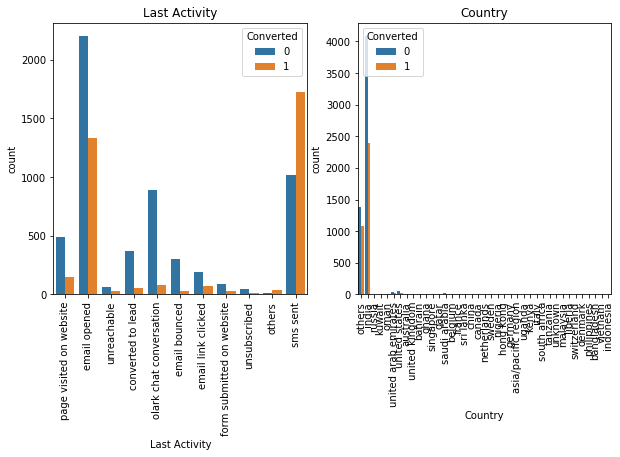

In [42]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.countplot(x='Last Activity', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('Last Activity')

plt.subplot(1,2,2)
sns.countplot(x='Country', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('Country')
plt.show()

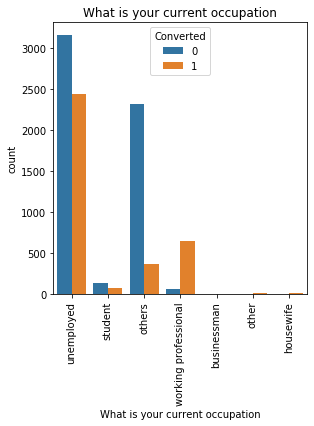

In [43]:
plt.figure(figsize = (10,5))

# plt.subplot(1,2,1)
# sns.countplot(x='Specialization', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
# plt.title('Specialization')

plt.subplot(1,2,1)
sns.countplot(x='What is your current occupation', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('What is your current occupation')
plt.show()

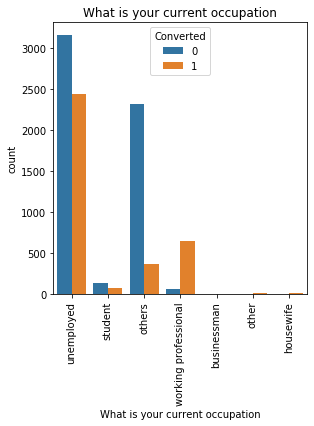

In [44]:
plt.figure(figsize = (10,5))

# plt.subplot(1,2,1)
# sns.countplot(x='Specialization', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
# plt.title('Specialization')

plt.subplot(1,2,1)
sns.countplot(x='What is your current occupation', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('What is your current occupation')
plt.show()

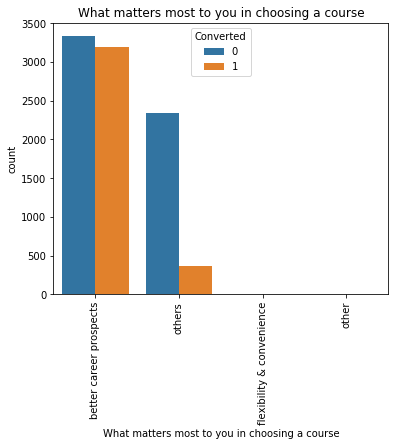

In [45]:
plt.figure(figsize = (6,5))

sns.countplot(x='What matters most to you in choosing a course', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('What matters most to you in choosing a course')

plt.show()

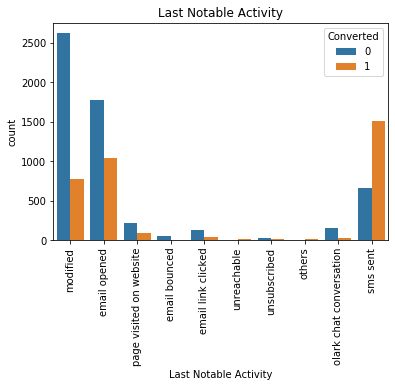

In [46]:
sns.countplot(x='Last Notable Activity', hue='Converted', data= df_final).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')
plt.show()

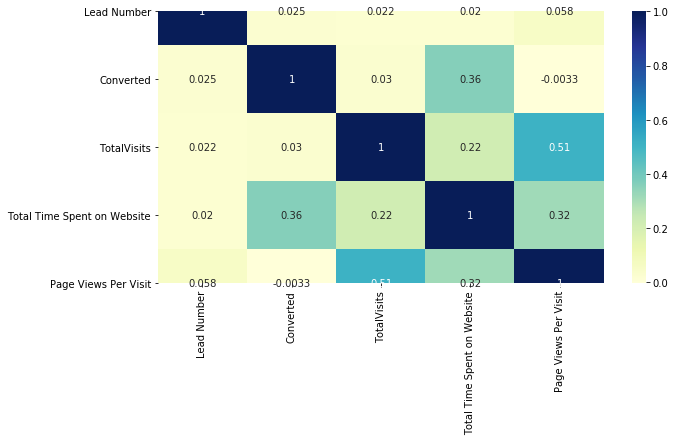

In [47]:
# Compute pairwise correlation of columns, excluding NA/null values
plt.figure(figsize=(10,5))
sns.heatmap(df_final.corr(method='pearson'),annot=True,cmap="YlGnBu")
plt.show()

### <font color= green>From the above heatmap it is observed that "coverted" column has strong corelation "Total time spent on website" of value 0.36.

## 3.2. Inspecting the Outliers

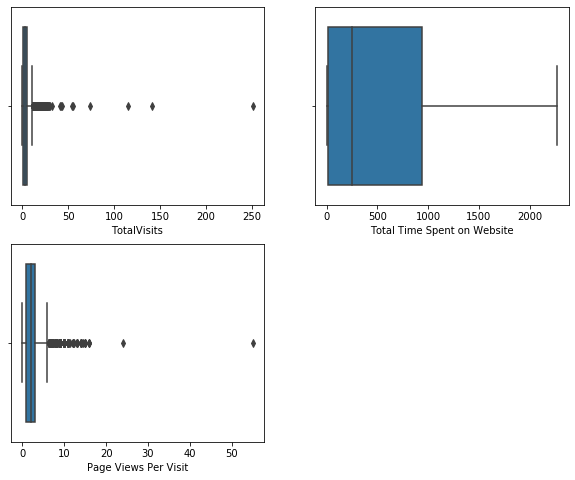

In [48]:
# Box Plot to find the outliers 
plt.figure(figsize = (10,8))

plt.subplot(2,2,1)
sns.boxplot('TotalVisits',data = df_final)
plt.subplot(2,2,2)
sns.boxplot('Total Time Spent on Website', data = df_final)
plt.subplot(2,2,3)
sns.boxplot('Page Views Per Visit',data = df_final)
plt.show()

#### outliers observed in the "TotalVisits" and "Page Views Per Visit". Capping of these outliers will help in the analysis

#### Capping of these Outliers will help for better analysis

## 3.3 Capping Outliers

In [49]:
# Capping Outliers:
columns = ["TotalVisits", "Page Views Per Visit"]
for col in columns:
    percentiles = df_final[col].quantile(0.99)
    df_final[col][df_final[col] >= percentiles] = percentiles

In [50]:
# After capping inspecting the dataframe

numeric = df_final[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']]
numeric.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9240.000000,9240.000000
mean,3.334415,487.698268,2.334429
std,3.228244,548.021466,1.970937
min,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000
50%,3.000000,248.000000,2.000000
75%,5.000000,936.000000,3.000000
90%,7.000000,1380.000000,5.000000
95%,10.000000,1562.000000,6.000000
99%,17.000000,1840.610000,9.000000


# 4. Data Preparation


In [51]:
# extracting the categorical columns

df_final.loc[:, df_final.dtypes == 'object'].columns

Index(['Lead Origin', 'Lead Source', 'Last Activity', 'Country',
       'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

### For categorical variables with multiple levels, creating dummy features (one-hot encoded)

In [52]:
# Create dummy variables using the 'get_dummies'
dummy = pd.get_dummies(df_final[['Lead Origin','Lead Source','Specialization', 'Last Activity', 'What is your current occupation','A free copy of Mastering The Interview', 'Last Notable Activity']], drop_first=True)
# concat the results to the master dataframe
df_final_dum = pd.concat([df_final, dummy], axis=1)
df_final_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9240 entries, 0 to 9239
Data columns (total 83 columns):
Lead Number                                             9240 non-null int64
Lead Origin                                             9240 non-null object
Lead Source                                             9240 non-null object
Converted                                               9240 non-null int64
TotalVisits                                             9240 non-null float64
Total Time Spent on Website                             9240 non-null int64
Page Views Per Visit                                    9240 non-null float64
Last Activity                                           9240 non-null object
Country                                                 9240 non-null object
Specialization                                          9240 non-null object
What is your current occupation                         9240 non-null object
What matters most to you in choosing a course  

In [53]:
df_final_dum = df_final_dum.drop(['Lead Origin','Tags','City', 'Lead Source','Last Activity', 'Country', 'Specialization', 'What is your current occupation','What matters most to you in choosing a course','A free copy of Mastering The Interview', 'Last Notable Activity'], 1)
df_final_dum.head()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_landing page submission,Lead Origin_lead add form,Lead Origin_lead import,Lead Origin_quick add form,Lead Source_blog,...,A free copy of Mastering The Interview_yes,Last Notable Activity_email link clicked,Last Notable Activity_email opened,Last Notable Activity_modified,Last Notable Activity_olark chat conversation,Last Notable Activity_others,Last Notable Activity_page visited on website,Last Notable Activity_sms sent,Last Notable Activity_unreachable,Last Notable Activity_unsubscribed
0,660737,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,660728,0,5.0,674,2.5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,660727,1,2.0,1532,2.0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,660719,0,1.0,305,1.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,660681,1,2.0,1428,1.0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 4.1 Test-Train Split

In [54]:
# Import the required library

from sklearn.model_selection import train_test_split

In [55]:
# Segregating the data into X dataframe and y

X = df_final_dum.drop(['Converted'], 1)
X.head()

,Lead Number,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_landing page submission,Lead Origin_lead add form,Lead Origin_lead import,Lead Origin_quick add form,Lead Source_blog,Lead Source_click2call,...,A free copy of Mastering The Interview_yes,Last Notable Activity_email link clicked,Last Notable Activity_email opened,Last Notable Activity_modified,Last Notable Activity_olark chat conversation,Last Notable Activity_others,Last Notable Activity_page visited on website,Last Notable Activity_sms sent,Last Notable Activity_unreachable,Last Notable Activity_unsubscribed
0,660737,0.0,0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,660728,5.0,674,2.5,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,660727,2.0,1532,2.0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,660719,1.0,305,1.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,660681,2.0,1428,1.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
# Traget variable y is Converted column

y = df_final_dum['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [57]:
# Split the dataset into 70% and 30% for train and test respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## 4.2 Feature Scaling

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
# Import MinMax scaler

from sklearn.preprocessing import MinMaxScaler

# Scale the three numeric features

scaler = MinMaxScaler()
X_train[['TotalVisits', 'Page Views Per Visit', 'Total Time Spent on Website']] = scaler.fit_transform(X_train[['TotalVisits', 'Page Views Per Visit', 'Total Time Spent on Website']])
X_train.head()

,Lead Number,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_landing page submission,Lead Origin_lead add form,Lead Origin_lead import,Lead Origin_quick add form,Lead Source_blog,Lead Source_click2call,...,A free copy of Mastering The Interview_yes,Last Notable Activity_email link clicked,Last Notable Activity_email opened,Last Notable Activity_modified,Last Notable Activity_olark chat conversation,Last Notable Activity_others,Last Notable Activity_page visited on website,Last Notable Activity_sms sent,Last Notable Activity_unreachable,Last Notable Activity_unsubscribed
1871,641410,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6795,597687,0.235294,0.214349,0.147778,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3516,626825,0.294118,0.046655,0.277778,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8105,587928,0.294118,0.541373,0.555556,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3934,622366,0.000000,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [60]:
X_train.describe()

,Lead Number,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_landing page submission,Lead Origin_lead add form,Lead Origin_lead import,Lead Origin_quick add form,Lead Source_blog,Lead Source_click2call,...,A free copy of Mastering The Interview_yes,Last Notable Activity_email link clicked,Last Notable Activity_email opened,Last Notable Activity_modified,Last Notable Activity_olark chat conversation,Last Notable Activity_others,Last Notable Activity_page visited on website,Last Notable Activity_sms sent,Last Notable Activity_unreachable,Last Notable Activity_unsubscribed
count,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,...,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000,6468.000000
mean,617186.001546,0.196343,0.212974,0.258259,0.528139,0.079468,0.005102,0.000155,0.000155,0.000464,...,0.311843,0.018398,0.305349,0.367811,0.018553,0.002319,0.035869,0.237477,0.003247,0.004793
std,23372.003514,0.191614,0.240566,0.218226,0.499246,0.270489,0.071252,0.012434,0.012434,0.021533,...,0.463282,0.134397,0.460591,0.482247,0.134950,0.048105,0.185978,0.425570,0.056892,0.069069
min,579533.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,596516.250000,0.058824,0.005282,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,615720.500000,0.176471,0.108275,0.222222,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,637348.750000,0.294118,0.407790,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,660728.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


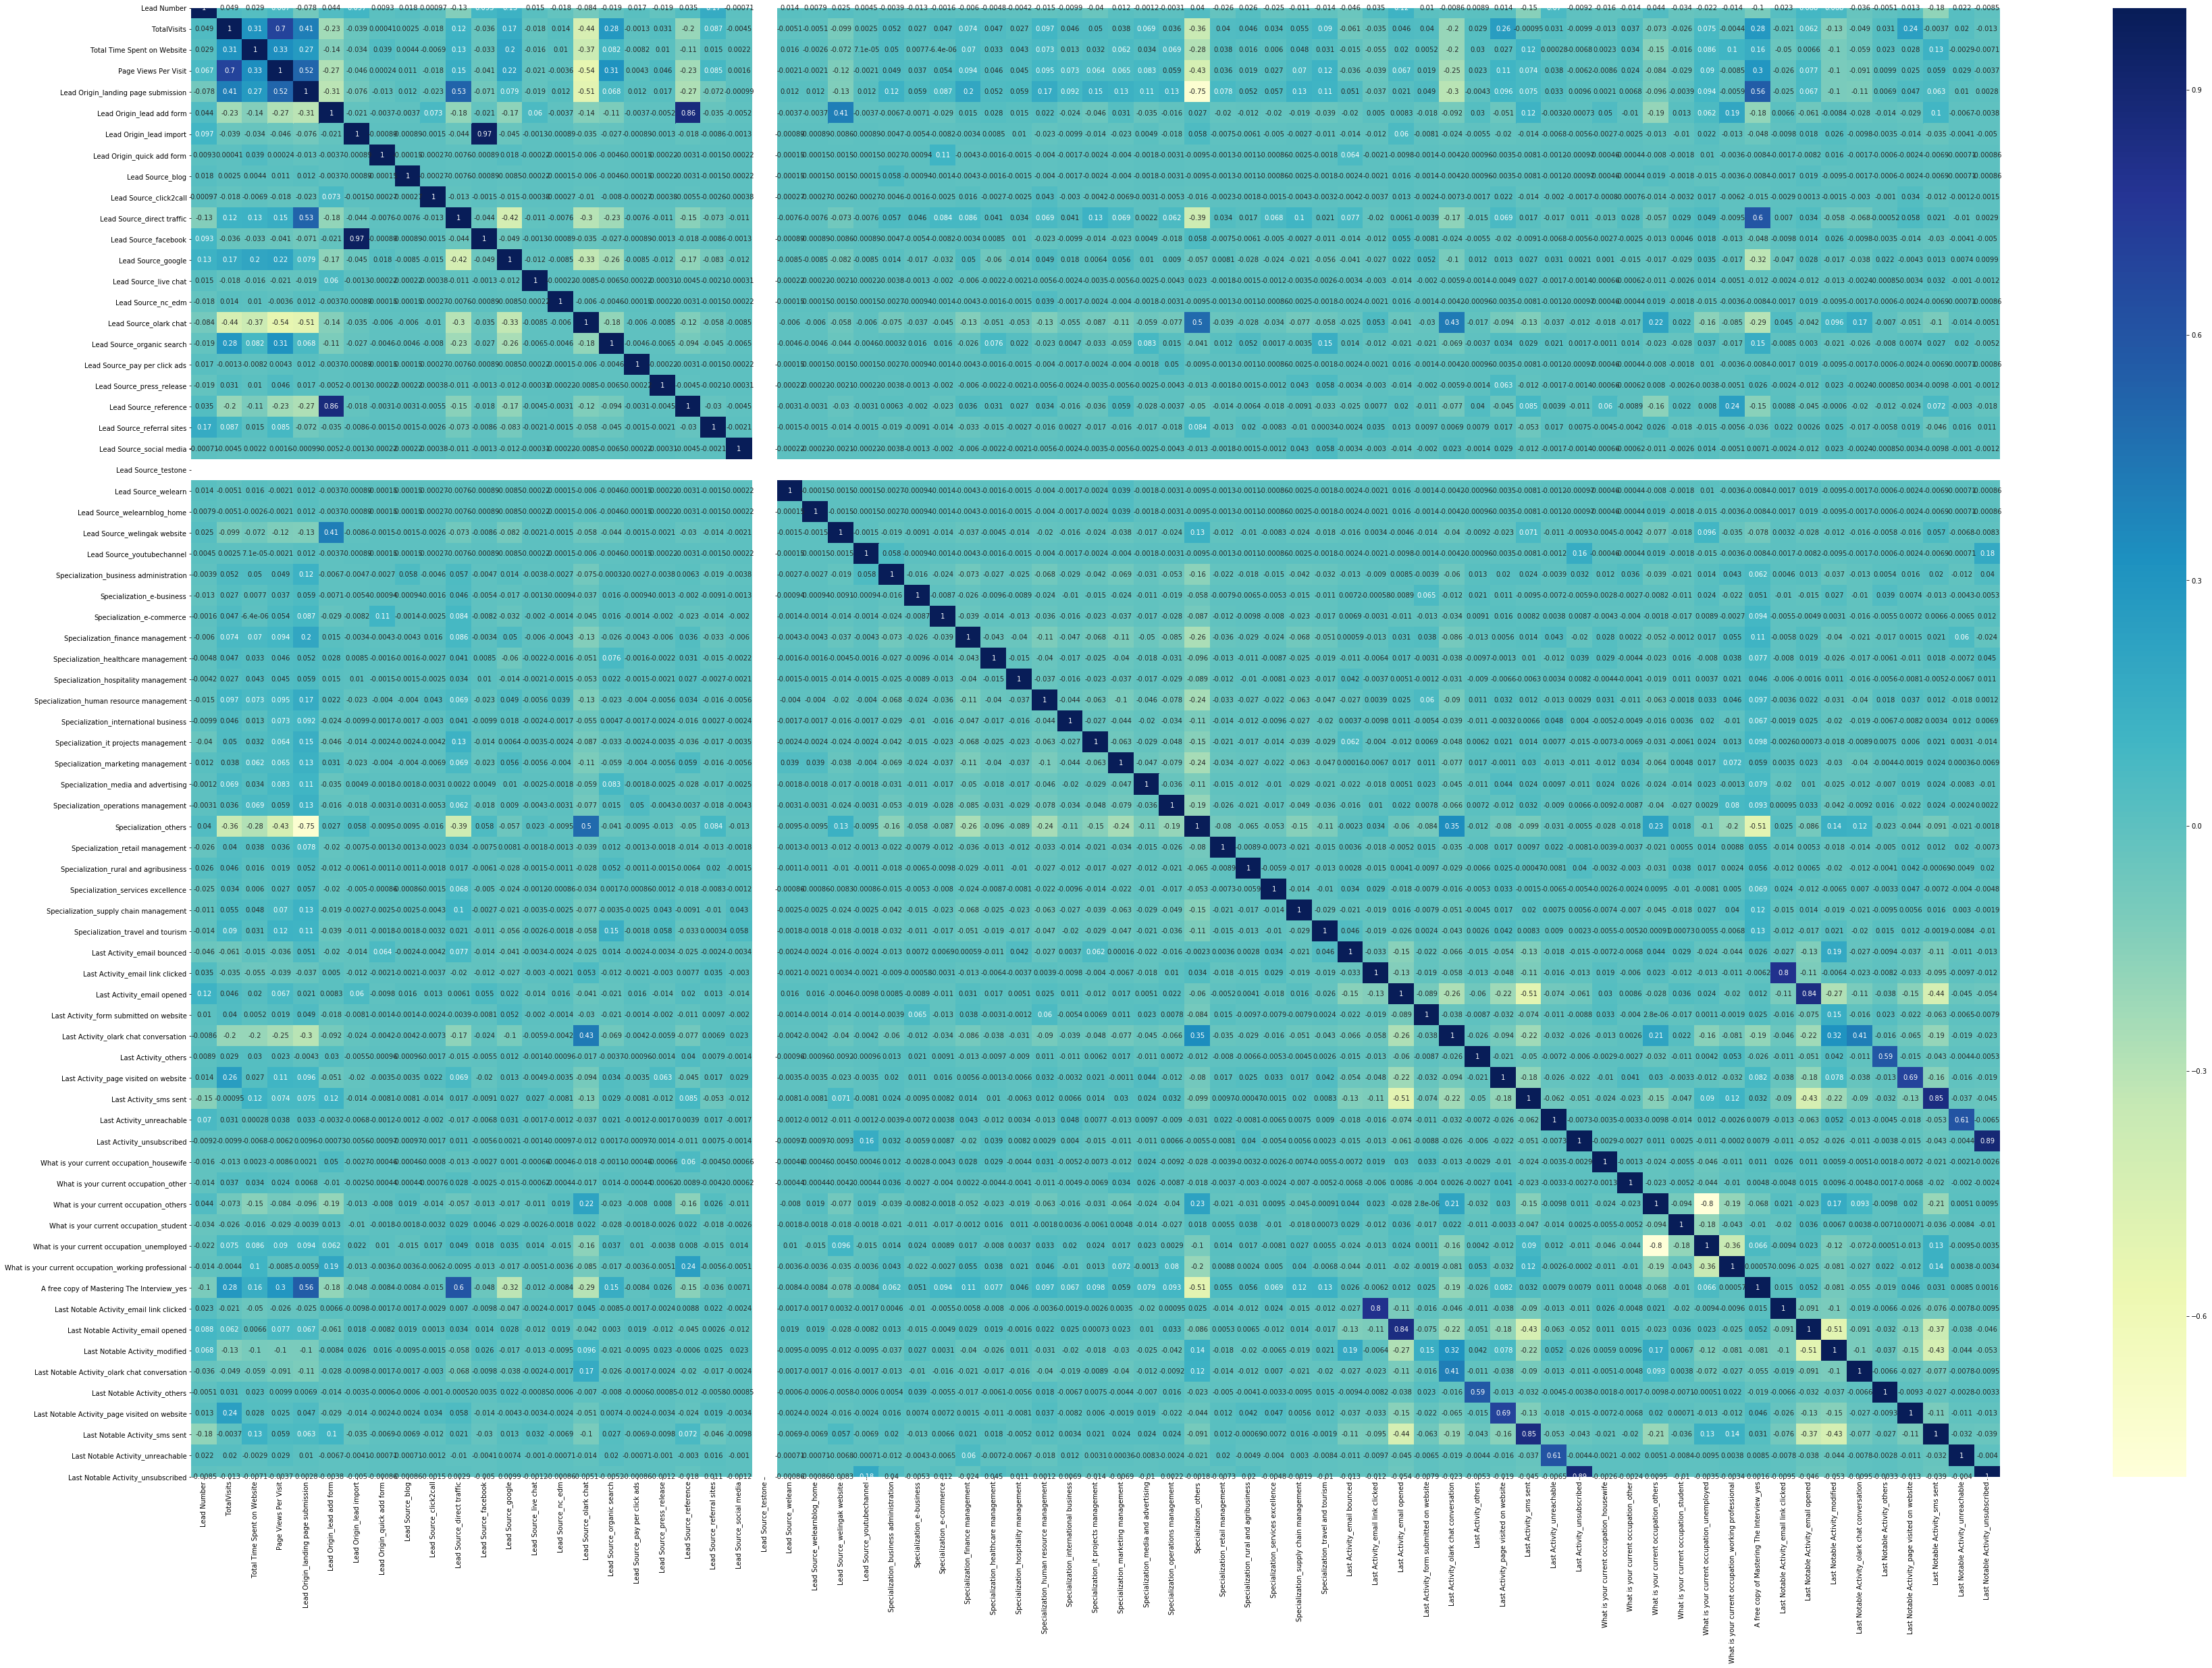

In [61]:
# To check the correlation among varibles
plt.figure(figsize=(60,40))
sns.heatmap(X_train.corr(),annot=True,cmap="YlGnBu")
plt.show()

In [62]:
X_train.shape

(6468, 71)

#### Since there are a lot of variables (82) it is difficult for data modeling and evaluation so, we can select the variables by RFE

## 5. Data Modelling and Evaluation
- Create Linear Regression model using mixed approach.
- Check the various assumptions.
- Check the Adjusted R-Square for both test and train data.
- Report the final model.

In [63]:
# Multilinear Regression using RFE
lm = LinearRegression()
lm.fit(X_train,y_train)

rfe = RFE(lm,20) # running RFE with 20 variables
rfe = rfe.fit(X_train,y_train)

# columns selected using RFE and displaying the columns along with there rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Lead Number', False, 51),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Lead Origin_landing page submission', False, 11),
 ('Lead Origin_lead add form', True, 1),
 ('Lead Origin_lead import', False, 22),
 ('Lead Origin_quick add form', True, 1),
 ('Lead Source_blog', True, 1),
 ('Lead Source_click2call', True, 1),
 ('Lead Source_direct traffic', False, 6),
 ('Lead Source_facebook', False, 3),
 ('Lead Source_google', False, 9),
 ('Lead Source_live chat', False, 20),
 ('Lead Source_nc_edm', True, 1),
 ('Lead Source_olark chat', False, 32),
 ('Lead Source_organic search', False, 8),
 ('Lead Source_pay per click ads', True, 1),
 ('Lead Source_press_release', False, 4),
 ('Lead Source_reference', False, 2),
 ('Lead Source_referral sites', False, 7),
 ('Lead Source_social media', False, 14),
 ('Lead Source_testone', False, 52),
 ('Lead Source_welearn', True, 1),
 ('Lead Source_welearnblog_home', True, 1),
 ('Lead Source_weling

In [64]:
# extracting top 20 columns as ranked by RFE
col = X_train.columns[rfe.support_]
col

Index(['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Lead Origin_lead add form', 'Lead Origin_quick add form',
       'Lead Source_blog', 'Lead Source_click2call', 'Lead Source_nc_edm',
       'Lead Source_pay per click ads', 'Lead Source_welearn',
       'Lead Source_welearnblog_home', 'Last Activity_email opened',
       'Last Activity_others', 'Last Activity_sms sent',
       'What is your current occupation_housewife',
       'What is your current occupation_others',
       'What is your current occupation_working professional',
       'Last Notable Activity_others', 'Last Notable Activity_sms sent',
       'Last Notable Activity_unreachable'],
      dtype='object')

In [65]:
# not needed columns
X_train.columns[~rfe.support_]

Index(['Lead Number', 'Lead Origin_landing page submission',
       'Lead Origin_lead import', 'Lead Source_direct traffic',
       'Lead Source_facebook', 'Lead Source_google', 'Lead Source_live chat',
       'Lead Source_olark chat', 'Lead Source_organic search',
       'Lead Source_press_release', 'Lead Source_reference',
       'Lead Source_referral sites', 'Lead Source_social media',
       'Lead Source_testone', 'Lead Source_welingak website',
       'Lead Source_youtubechannel', 'Specialization_business administration',
       'Specialization_e-business', 'Specialization_e-commerce',
       'Specialization_finance management',
       'Specialization_healthcare management',
       'Specialization_hospitality management',
       'Specialization_human resource management',
       'Specialization_international business',
       'Specialization_it projects management',
       'Specialization_marketing management',
       'Specialization_media and advertising',
       'Specialization_

## 5.1 Model Building  Using Statsmodel

In [66]:
# creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [67]:
# Adding the constant to train data set
X_train_rfe1 = sm.add_constant(X_train_rfe)

# Create the Model
lm = sm.OLS(y_train,X_train_rfe1)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     236.3
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:37   Log-Likelihood:                -2728.6
No. Observations:                6468   AIC:                             5499.
Df Residuals:                    6447   BIC:                             5641.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [68]:
# Variance Inflation factor (VIF) for the X_train Data set
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF']= [variance_inflation_factor(X_train_rfe.values,i)for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
13,Last Activity_sms sent,5.61
18,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.06
11,Last Activity_email opened,1.77
12,Last Activity_others,1.55
17,Last Notable Activity_others,1.53
3,Lead Origin_lead add form,1.24
15,What is your current occupation_others,1.24


In [69]:
# Dropping the column having p value greater than 0.05 (i.e. 0.769)
X_train_new = X_train_rfe.drop('Lead Source_click2call',axis=1)

In [70]:
# Adding the constant to train data set
X_train_rfe1 = sm.add_constant(X_train_new)

# Recreate the Model after droping the column: Humidity (hum)
lm = sm.OLS(y_train,X_train_rfe1)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     248.7
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:37   Log-Likelihood:                -2728.6
No. Observations:                6468   AIC:                             5497.
Df Residuals:                    6448   BIC:                             5633.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [71]:
# Variance Inflation factor (VIF) for the X_train Data set after dropping the column
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF']= [variance_inflation_factor(X_train_new.values,i)for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
12,Last Activity_sms sent,5.61
17,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.06
10,Last Activity_email opened,1.77
11,Last Activity_others,1.55
16,Last Notable Activity_others,1.53
14,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [72]:
# drop Lead Source_welearnblog_home
# Drop the variable Lead Source_welearnblog_home is having 0.646 p value
X_train_new2 = X_train_new.drop('Lead Source_welearnblog_home',axis=1)

# Adding the constant to train data set
X_train_rfe2 = sm.add_constant(X_train_new2)

# Recreate the Model after droping the column
lm = sm.OLS(y_train,X_train_rfe2)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     262.6
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:37   Log-Likelihood:                -2728.7
No. Observations:                6468   AIC:                             5495.
Df Residuals:                    6449   BIC:                             5624.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [73]:
# Variance Inflation factor (VIF) for the X_train Data set after dropping the column: Lead Source_welearnblog_home
vif = pd.DataFrame()
vif['Features'] = X_train_new2.columns
vif['VIF']= [variance_inflation_factor(X_train_new2.values,i)for i in range(X_train_new2.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
11,Last Activity_sms sent,5.61
16,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.06
9,Last Activity_email opened,1.77
10,Last Activity_others,1.55
15,Last Notable Activity_others,1.53
13,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [74]:
# Drop the variable Lead Source_pay per click ads is having 0.572 p value
X_train_new3 = X_train_new2.drop('Lead Source_pay per click ads',axis=1)

# Adding the constant to train data set
X_train_rfe3 = sm.add_constant(X_train_new3)

# Recreate the Model after droping the column: Humidity (hum)
lm = sm.OLS(y_train,X_train_rfe3)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     278.0
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:38   Log-Likelihood:                -2728.9
No. Observations:                6468   AIC:                             5494.
Df Residuals:                    6450   BIC:                             5616.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [75]:
# Variance Inflation factor (VIF) for the X_train Data set after dropping the column: Temperature (temp)
vif = pd.DataFrame()
vif['Features'] = X_train_new3.columns
vif['VIF']= [variance_inflation_factor(X_train_new3.values,i)for i in range(X_train_new3.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
10,Last Activity_sms sent,5.61
15,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.06
8,Last Activity_email opened,1.77
9,Last Activity_others,1.55
14,Last Notable Activity_others,1.53
12,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [76]:
# Dropping the Column: Lead Source_blog is having P- value : 0.565 i.e. greater than 0.05 (5%) (significance level - 5%)
X_train_new4 = X_train_new3.drop('Lead Source_blog',axis =1)

# Adding the constant to train data set
X_train_rfe4 = sm.add_constant(X_train_new4)

# Recreate the Model after droping the column: holiday
lm = sm.OLS(y_train,X_train_rfe4)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     295.4
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:38   Log-Likelihood:                -2729.1
No. Observations:                6468   AIC:                             5492.
Df Residuals:                    6451   BIC:                             5607.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [77]:
# Variance Inflation factor (VIF) for the X_train Data set after dropping the column: holiday
vif = pd.DataFrame()
vif['Features'] = X_train_new4.columns
vif['VIF']= [variance_inflation_factor(X_train_new4.values,i)for i in range(X_train_new4.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
9,Last Activity_sms sent,5.61
14,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.06
7,Last Activity_email opened,1.77
8,Last Activity_others,1.55
13,Last Notable Activity_others,1.53
11,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [78]:
# Dropping the Column: Lead Origin_quick add form is having P- value : 0.466 i.e. greater than 0.05 (5%) (significance level - 5%)
X_train_new5 = X_train_new4.drop('Lead Origin_quick add form',axis =1)

# Adding the constant to train data set
X_train_rfe5 = sm.add_constant(X_train_new5)

# Recreate the Model after droping the column: holiday
lm = sm.OLS(y_train,X_train_rfe5)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     315.1
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:38   Log-Likelihood:                -2729.3
No. Observations:                6468   AIC:                             5491.
Df Residuals:                    6452   BIC:                             5599.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [79]:
# Variance Inflation factor (VIF) for the X_train Data set after dropping the column: holiday
vif = pd.DataFrame()
vif['Features'] = X_train_new5.columns
vif['VIF']= [variance_inflation_factor(X_train_new5.values,i)for i in range(X_train_new5.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
8,Last Activity_sms sent,5.61
13,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.05
6,Last Activity_email opened,1.77
7,Last Activity_others,1.55
12,Last Notable Activity_others,1.53
10,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [80]:
# Dropping the Column: Lead Source_welearn is having P- value : 0.228 i.e. greater than 0.05 (5%) (significance level - 5%)
X_train_new6 = X_train_new5.drop('Lead Source_welearn',axis =1)

# Adding the constant to train data set
X_train_rfe6 = sm.add_constant(X_train_new6)

# Recreate the Model after droping the column: holiday
lm = sm.OLS(y_train,X_train_rfe6)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     337.5
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:39   Log-Likelihood:                -2730.0
No. Observations:                6468   AIC:                             5490.
Df Residuals:                    6453   BIC:                             5592.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [81]:
 # Variance Inflation factor (VIF) for the X_train Data set after dropping the column: holiday
vif = pd.DataFrame()
vif['Features'] = X_train_new6.columns
vif['VIF']= [variance_inflation_factor(X_train_new6.values,i)for i in range(X_train_new6.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,Last Activity_sms sent,5.61
12,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.05
5,Last Activity_email opened,1.77
6,Last Activity_others,1.55
11,Last Notable Activity_others,1.53
9,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [82]:
# Dropping the Column: Lead Source_nc_edm is having P- value : 0.109 i.e. greater than 0.05 (5%) (significance level - 5%)
X_train_new7 = X_train_new6.drop('Lead Source_nc_edm',axis =1)

# Adding the constant to train data set
X_train_rfe7 = sm.add_constant(X_train_new7)

# Recreate the Model after droping the column: holiday
lm = sm.OLS(y_train,X_train_rfe7)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     363.1
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:39   Log-Likelihood:                -2731.3
No. Observations:                6468   AIC:                             5491.
Df Residuals:                    6454   BIC:                             5586.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [83]:
 # Variance Inflation factor (VIF) for the X_train Data set after dropping the column: holiday
vif = pd.DataFrame()
vif['Features'] = X_train_new7.columns
vif['VIF']= [variance_inflation_factor(X_train_new7.values,i)for i in range(X_train_new7.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
6,Last Activity_sms sent,5.61
11,Last Notable Activity_sms sent,4.89
2,Page Views Per Visit,4.86
0,TotalVisits,3.98
1,Total Time Spent on Website,2.05
4,Last Activity_email opened,1.77
5,Last Activity_others,1.55
10,Last Notable Activity_others,1.53
8,What is your current occupation_others,1.24
3,Lead Origin_lead add form,1.23


In [84]:
# Dropping the Column: Last Activity_sms sent is having VIF- value : 5.61 i.e. greater than 0.05 (5%) (significance level - 5%)
X_train_new8 = X_train_new7.drop('Last Activity_sms sent',axis =1)

# Adding the constant to train data set
X_train_rfe8 = sm.add_constant(X_train_new8)

# Recreate the Model after droping the column: holiday
lm = sm.OLS(y_train,X_train_rfe8)

# fit 
lm = lm.fit()

# summary of linear model
print('Summary of Linear Model: \n',lm.summary())

Summary of Linear Model: 
                             OLS Regression Results                            
Dep. Variable:              Converted   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     383.0
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        22:58:39   Log-Likelihood:                -2768.0
No. Observations:                6468   AIC:                             5562.
Df Residuals:                    6455   BIC:                             5650.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [85]:
# Variance Inflation factor (VIF) for the X_train Data set after dropping the column: holiday
vif = pd.DataFrame()
vif['Features'] = X_train_new8.columns
vif['VIF']= [variance_inflation_factor(X_train_new8.values,i)for i in range(X_train_new8.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Page Views Per Visit,4.73
0,TotalVisits,3.98
1,Total Time Spent on Website,2.03
4,Last Activity_email opened,1.66
5,Last Activity_others,1.55
9,Last Notable Activity_others,1.53
10,Last Notable Activity_sms sent,1.51
7,What is your current occupation_others,1.20
3,Lead Origin_lead add form,1.19
8,What is your current occupation_working profes...,1.17


## 6. Model Prediction

### Residual Analysis of the Train Data

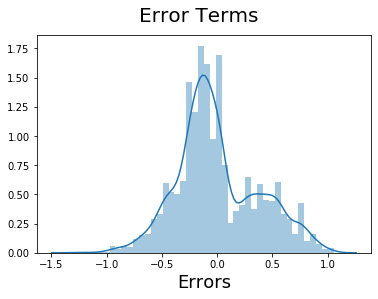

In [86]:
y_train_pred = lm.predict(X_train_rfe8)
# calculate the residual and ploting the distribution curve 
res = y_train - y_train_pred
fig = plt.figure()
sns.distplot(res)
fig.suptitle('Error Terms',fontsize = 20)
plt.xlabel("Errors",fontsize = 18)
plt.show()

In [87]:
# Predicting the probabilities on the train set
y_train_pred[:10]

1871    0.237032
6795    0.385325
3516    0.239643
8105    0.722478
3934    0.237032
4844    1.208996
3297    0.221215
8071    1.169534
987     0.222103
7423    0.921324
dtype: float64

In [88]:
# Reshaping to an array
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.23703166, 0.38532532, 0.23964345, 0.72247822, 0.23703166,
       1.20899553, 0.22121502, 1.16953383, 0.22210251, 0.92132446])

In [89]:
# Data frame with given convertion rate and probablity of predicted ones
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Conversion_Prob':y_train_pred})
y_train_pred_final.head()

,Converted,Conversion_Prob
0,0,0.237032
1,0,0.385325
2,0,0.239643
3,0,0.722478
4,0,0.237032


In [90]:
# Substituting 0 or 1 with the cut off as 0.5
y_train_pred_final['Predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted
0,0,0.237032,0
1,0,0.385325,0
2,0,0.239643,0
3,0,0.722478,1
4,0,0.237032,0


Text(0, 0.5, 'y_pred')

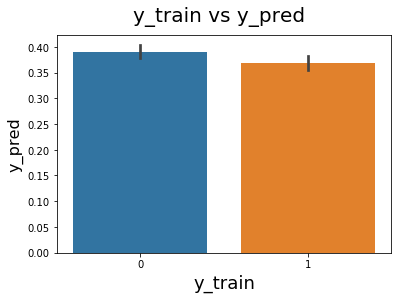

In [91]:
# plotting y_train  and y_train_pred to understand the spread
fig = plt.figure()
sns.barplot(y_train,y_train_pred)
#sns.regplot(y_train,y_train_pred)
fig.suptitle('y_train vs y_pred',fontsize = 20)
plt.xlabel('y_train', fontsize = 18)
plt.ylabel('y_pred',fontsize = 16)

## 7. Model Evaluation

In [92]:
# Creating confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3590,  412],
       [ 814, 1652]], dtype=int64)

In [93]:
# Check the overall accuracy
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted)

0.8104514533085961

#### The accuracy of model is 81% hence, it is a good model

In [94]:
# Substituting the value of true positive
TP = confusion[1,1]
# Substituting the value of true negatives
TN = confusion[0,0]
# Substituting the value of false positives
FP = confusion[0,1] 
# Substituting the value of false negatives
FN = confusion[1,0]

In [95]:
# Calculating the sensitivity
TP/(TP+FN)

0.6699107866991079

In [96]:
# Calculating the specificity
TN/(TN+FP)

0.8970514742628686

#### With the current cut off as 0.5 we have around 81% accuracy, sensitivity of around 66.99% and specificity of around 89.70%.

## 8. Optimise Cut off (ROC Curve)

The previous cut off was randomely selected. Now to find the optimum one

In [97]:
# ROC function
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [98]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob, drop_intermediate = False )

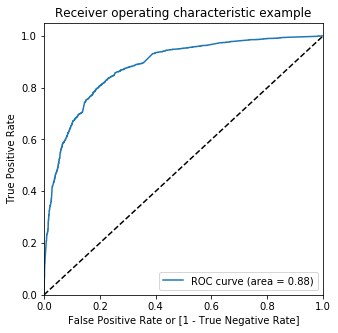

In [99]:
# Call the ROC function
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

#### The area under ROC curve is 0.88 which is a very good value.

In [100]:
# Creating columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.237032,0,1,1,1,0,0,0,0,0,0,0
1,0,0.385325,0,1,1,1,1,0,0,0,0,0,0
2,0,0.239643,0,1,1,1,0,0,0,0,0,0,0
3,0,0.722478,1,1,1,1,1,1,1,1,1,0,0
4,0,0.237032,0,1,1,1,0,0,0,0,0,0,0


In [101]:
# Creating a dataframe to see the values of accuracy, sensitivity, and specificity at different values of probabiity cutoffs
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
# Making confusing matrix to find values of sensitivity, accurace and specificity for each level of probablity
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df

,prob,accuracy,sensi,speci
0.0,0.0,0.467223,0.993917,0.142679
0.1,0.1,0.542826,0.983779,0.271114
0.2,0.2,0.699134,0.946878,0.546477
0.3,0.3,0.778448,0.869424,0.722389
0.4,0.4,0.803649,0.800487,0.805597
0.5,0.5,0.810451,0.669911,0.897051
0.6,0.6,0.785405,0.527981,0.944028
0.7,0.7,0.760049,0.420519,0.969265
0.8,0.8,0.716296,0.280616,0.984758
0.9,0.9,0.692950,0.207624,0.992004


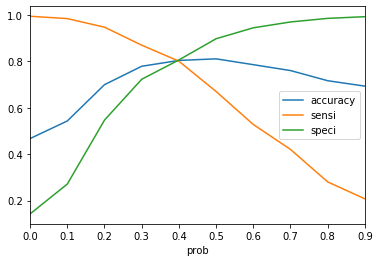

In [102]:
# Plotting it
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the graph it is visible that the optimal cut off is at 0.35

In [103]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map( lambda x: 1 if x > 0.40 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.237032,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.385325,0,1,1,1,1,0,0,0,0,0,0,0
2,0,0.239643,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.722478,1,1,1,1,1,1,1,1,1,0,0,1
4,0,0.237032,0,1,1,1,0,0,0,0,0,0,0,0


In [104]:
# Check the overall accuracy
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8036487322201608

In [105]:
# Creating confusion matrix 
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3224,  778],
       [ 492, 1974]], dtype=int64)

In [106]:
# Substituting the value of true positive
TP = confusion2[1,1]
# Substituting the value of true negatives
TN = confusion2[0,0]
# Substituting the value of false positives
FP = confusion2[0,1] 
# Substituting the value of false negatives
FN = confusion2[1,0]

In [107]:
# Calculating the sensitivity
TP/(TP+FN)

0.8004866180048662

In [108]:
# Calculating the specificity
TN/(TN+FP)

0.8055972013993004

#### With the current cut off as 0.40 we have accuracy: 80.03%, sensitivity: 80.04% and specificity of around 80.05%.

## 9. Prediction on Test set

In [109]:
# list of numaric variables
num_vars=['TotalVisits', 'Page Views Per Visit', 'Total Time Spent on Website']

# transform 
X_test[num_vars]=scaler.transform(X_test[num_vars])

# checking the variables after transforming data using train data set 
print('Scaling of Test Data set:  \n ',X_test[num_vars].describe()) 

Scaling of Test Data set:  
         TotalVisits  Page Views Per Visit  Total Time Spent on Website
count  2772.000000           2772.000000                  2772.000000
mean      0.195674              0.262000                     0.218582
std       0.185862              0.220791                     0.242693
min       0.000000              0.000000                     0.000000
25%       0.058824              0.111111                     0.005722
50%       0.176471              0.222222                     0.113556
75%       0.294118              0.388889                     0.417694
max       1.000000              1.000000                     0.991637


#### We can observe that, the maximum value of test data variables  are near about 1 or slightly above 1, but not exactly 1. Because the MinMaxScaler was fit and transform on train data set and later we are tranforming it on test data. Hence its max values are near about 1 but not exactly 1

In [110]:
# Substituting all the columns in the final train model
col = X_train_new8.columns

In [111]:
# Select the columns in X_train for X_test as well
X_test = X_test[col]
# Add a constant to X_test
X_test_sm = sm.add_constant(X_test[col])
X_test_sm.head()
print(X_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2772 entries, 4269 to 2960
Data columns (total 12 columns):
TotalVisits                                             2772 non-null float64
Total Time Spent on Website                             2772 non-null float64
Page Views Per Visit                                    2772 non-null float64
Lead Origin_lead add form                               2772 non-null uint8
Last Activity_email opened                              2772 non-null uint8
Last Activity_others                                    2772 non-null uint8
What is your current occupation_housewife               2772 non-null uint8
What is your current occupation_others                  2772 non-null uint8
What is your current occupation_working professional    2772 non-null uint8
Last Notable Activity_others                            2772 non-null uint8
Last Notable Activity_sms sent                          2772 non-null uint8
Last Notable Activity_unreachable               

In [112]:
# Storing prediction of test set in the variable 'y_test_pred'
y_test_pred = lm.predict(X_test_sm)
# Coverting it to df
y_pred_df = pd.DataFrame(y_test_pred)
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Remove index for both dataframes to append them side by side 
y_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
# Append y_test_df and y_pred_df
y_pred_final = pd.concat([y_test_df, y_pred_df],axis=1)
# Renaming column 
y_pred_final= y_pred_final.rename(columns = {0 : 'Conversion_Prob'})
y_pred_final.head()

,Converted,Conversion_Prob
0,1,0.452708
1,1,0.930498
2,1,0.751296
3,0,0.128469
4,1,0.708309


In [113]:
# Making prediction using cut off 0.35
y_pred_final['final_predicted'] = y_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.40 else 0)
y_pred_final

,Converted,Conversion_Prob,final_predicted
0,1,0.452708,1
1,1,0.930498,1
2,1,0.751296,1
3,0,0.128469,0
4,1,0.708309,1
...,...,...,...
2767,0,0.196930,0
2768,1,0.930498,1
2769,0,0.237032,0
2770,0,0.419857,1


In [114]:
# Check the overall accuracy
metrics.accuracy_score(y_pred_final['Converted'], y_pred_final.final_predicted)

0.8044733044733045

In [115]:
# Creating confusion matrix 
confusion2 = metrics.confusion_matrix(y_pred_final['Converted'], y_pred_final.final_predicted )
confusion2

array([[1358,  319],
       [ 223,  872]], dtype=int64)

In [116]:
# Substituting the value of true positive
TP = confusion2[1,1]
# Substituting the value of true negatives
TN = confusion2[0,0]
# Substituting the value of false positives
FP = confusion2[0,1] 
# Substituting the value of false negatives
FN = confusion2[1,0]

In [117]:
# Calculating the sensitivity
TP/(TP+FN)

0.7963470319634703

In [118]:
# Calculating the specificity
TN/(TN+FP)

0.8097793679189028

#### With the current cut off as 0.40 we have accuracy: 80.44%, sensitivity: 79.63% and specificity of around 80.97%.

## 10.Precision-Recall

In [119]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
confusion

array([[3590,  412],
       [ 814, 1652]], dtype=int64)

In [120]:
# Precision = TP / TP + FP
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.8003875968992248

In [121]:
#Recall = TP / TP + FN
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.6699107866991079

#### With the current cut off as 0.40 we have Precision around 80.03% and Recall around 66.99%

### Precision and recall tradeoff

In [122]:
from sklearn.metrics import precision_recall_curve

In [123]:
y_train_pred_final.Converted, y_train_pred_final.Predicted

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 6463    1
 6464    1
 6465    1
 6466    0
 6467    0
 Name: Converted, Length: 6468, dtype: int64, 0       0
 1       0
 2       0
 3       1
 4       0
        ..
 6463    1
 6464    1
 6465    0
 6466    0
 6467    0
 Name: Predicted, Length: 6468, dtype: int64)

In [124]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

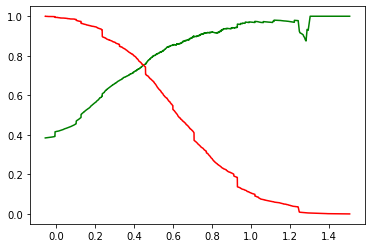

In [125]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

#### From the above plot we can predict the cut off 0.42.

In [126]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.42 else 0)
y_train_pred_final.head()

,Converted,Conversion_Prob,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.237032,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.385325,0,1,1,1,1,0,0,0,0,0,0,0
2,0,0.239643,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.722478,1,1,1,1,1,1,1,1,1,0,0,1
4,0,0.237032,0,1,1,1,0,0,0,0,0,0,0,0


In [127]:
# Accuracy
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.8075139146567718

In [128]:
# Creating confusion matrix again
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3294,  708],
       [ 537, 1929]], dtype=int64)

In [129]:
# Substituting the value of true positive
TP = confusion2[1,1]
# Substituting the value of true negatives
TN = confusion2[0,0]
# Substituting the value of false positives
FP = confusion2[0,1] 
# Substituting the value of false negatives
FN = confusion2[1,0]

In [130]:
# Precision = TP / TP + FP
TP / (TP + FP)

0.7315130830489193

In [131]:
#Recall = TP / TP + FN
TP / (TP + FN)

0.7822384428223844

#### With the current cut off as 0.42 we have Precision around 73.15% and Recall around 78.22%

# 11.Conclusion

It was found that the variables that mattered the most in the potential buyers are (In descending order) :

1. The total time spend on the Website.
2. What is your current occupation_housewife.
3. When the lead source was: <br>
a. Google<br>
b. Direct traffic<br>
c. Organic search<br>
4. Lead Origin_lead add form.
5. What is your current occupation_working professional.
6. Last Notable Activity_unreachable: <br> 
a. modified<br>
b. email opened<br>
c. sms sent<br>
7. Last Activity_others
8. TotalVisits
9. What is your current occupation_student
10. What is your current occupation_unemployed.
11. Last Activity<br>
a.email opened <br>
b.sms sent <br>
c.olark chat conversation.<br>

Keeping these in mind the X Education can flourish as they have a very high chance to get almost all the potential buyers to change their mind and buy their courses.



SOME OF THE VARIABLES AR NEGATIVE POTENTIAL BUYERS as follows:
1. const
2. Page Views Per Visit
3. Lead Source_reference.